In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import arviz as az
import pymc as pm
import pymc.sampling_jax
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
y = np.array(
    [
        26.0,
        35.0,
        30,
        25,
        44,
        30,
        33,
        43,
        22,
        43,
        24,
        19,
        39,
        31,
        25,
        28,
        35,
        30,
        26,
        31,
        41,
        36,
        26,
        35,
        33,
        28,
        27,
        34,
        27,
        22,
    ]
)

df = pd.DataFrame()
df["y"] = y

In [4]:
np.mean(y)

30.933333333333334

In [5]:
def metropolis(logp, qdraw, stepsize, nsamp, xinit):
    samples = np.empty(nsamp)
    x_prev = xinit
    accepted = 0
    for i in range(nsamp):
        x_star = qdraw(x_prev, stepsize)
        logp_star = logp(x_star)
        logp_prev = logp(x_prev)
        logpdfratio = logp_star - logp_prev
        u = np.random.uniform()
        if np.log(u) <= logpdfratio:
            samples[i] = x_star
            x_prev = x_star
            accepted += 1
        else:  # we always get a sample
            samples[i] = x_prev

    return samples, accepted

In [6]:
def prop(x, step):
    return np.random.normal(x, step)

In [7]:
# Prior mean
mu_prior = 30
# prior std
std_prior = 5

In [8]:
logprior = lambda mu: stats.norm.logpdf(mu, loc=mu_prior, scale=std_prior)
loglike = lambda mu: np.sum(stats.norm.logpdf(y, loc=mu, scale=np.std(y)))
logpost = lambda mu: loglike(mu) + logprior(mu)

In [9]:
x0 = np.random.uniform()
nsamps = 100000

samps, acc = metropolis(logpost, prop, 3, nsamps, x0)

In [10]:
acc / nsamps

0.41601

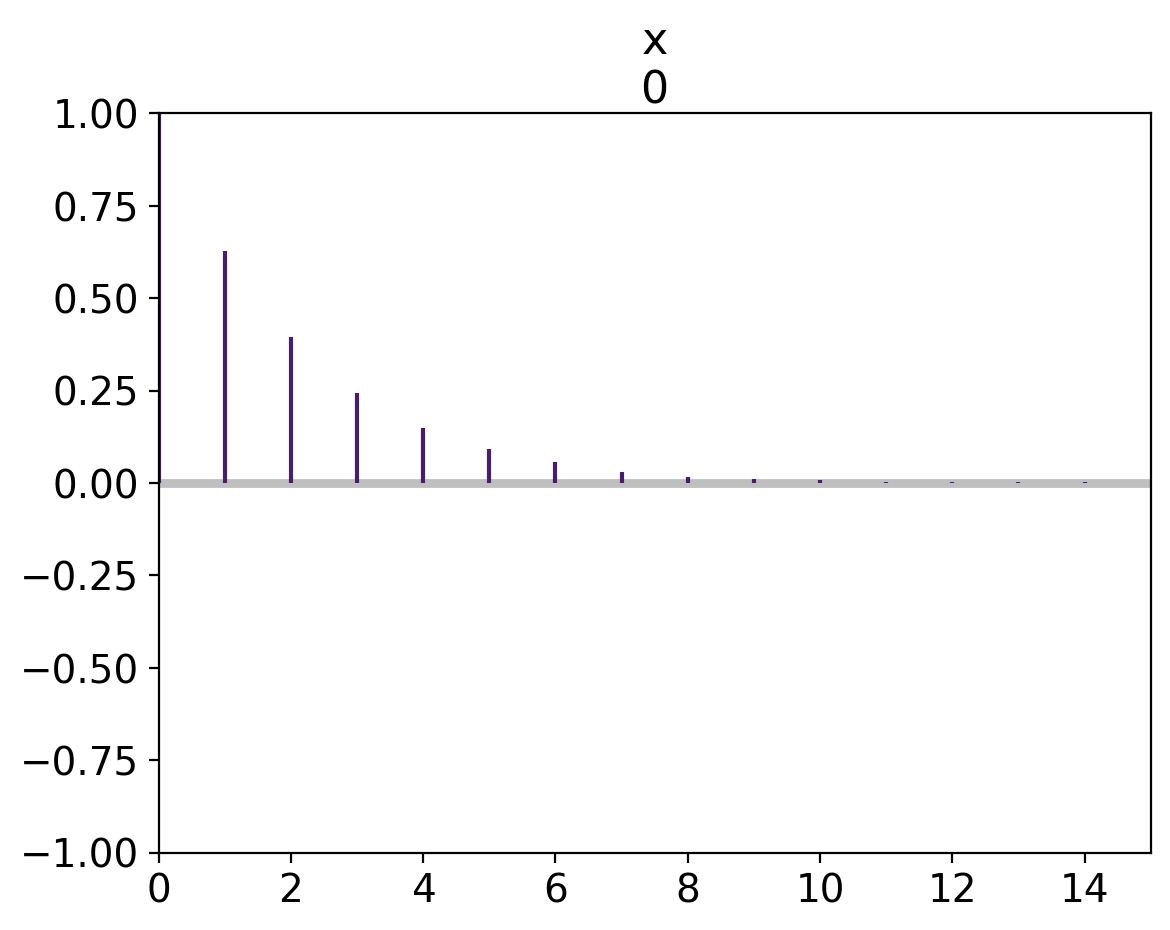

In [11]:
az.plot_autocorr(samps[40000::], max_lag=15)
plt.show()

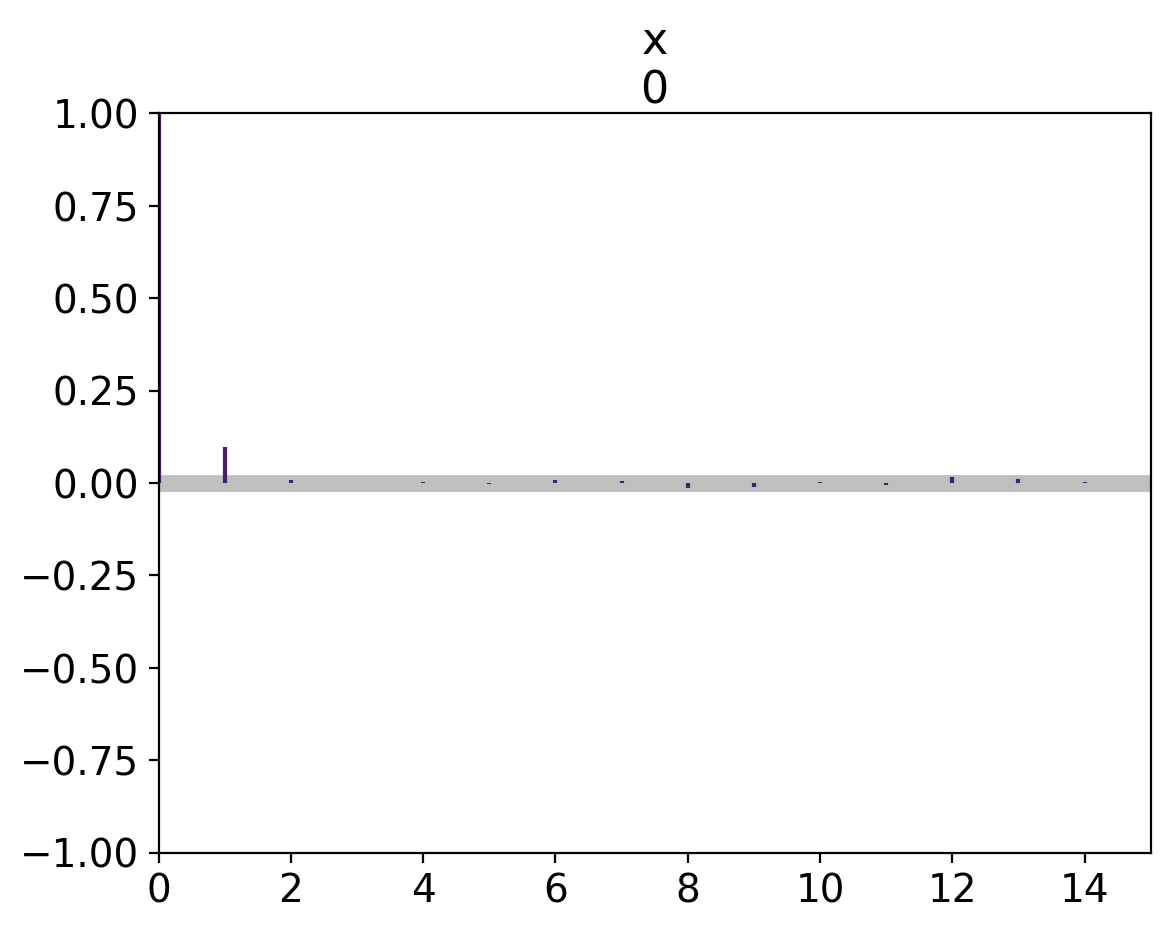

In [12]:
az.plot_autocorr(samps[40000::5], max_lag=15)
plt.show()

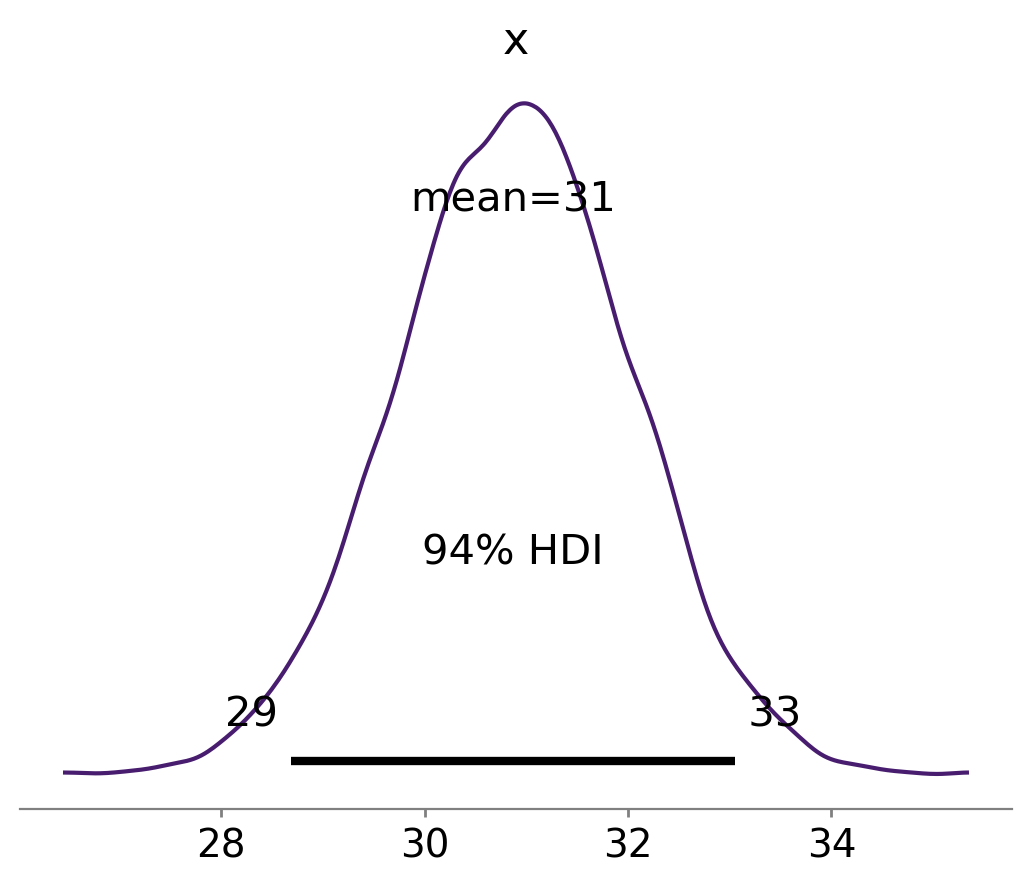

In [13]:
az.plot_posterior(samps[40000::5], hdi_prob=0.94)
plt.show()

In [14]:
az.hdi(samps[40000::5], hdi_prob=0.94)

array([28.68800142, 33.0494141 ])

In [15]:
sigma = np.std(df["y"])
sigma

6.495810615739621

In [16]:
with pm.Model() as model:
    data = pm.ConstantData("data", df["y"])
    mu = pm.Normal("mu", mu=30, sigma=5)
    pm.Normal("y", mu=mu, sigma=np.std(df["y"]), observed=data)

In [17]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:01.079945
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.288401
Transforming variables...
Transformation time =  0:00:00.003869


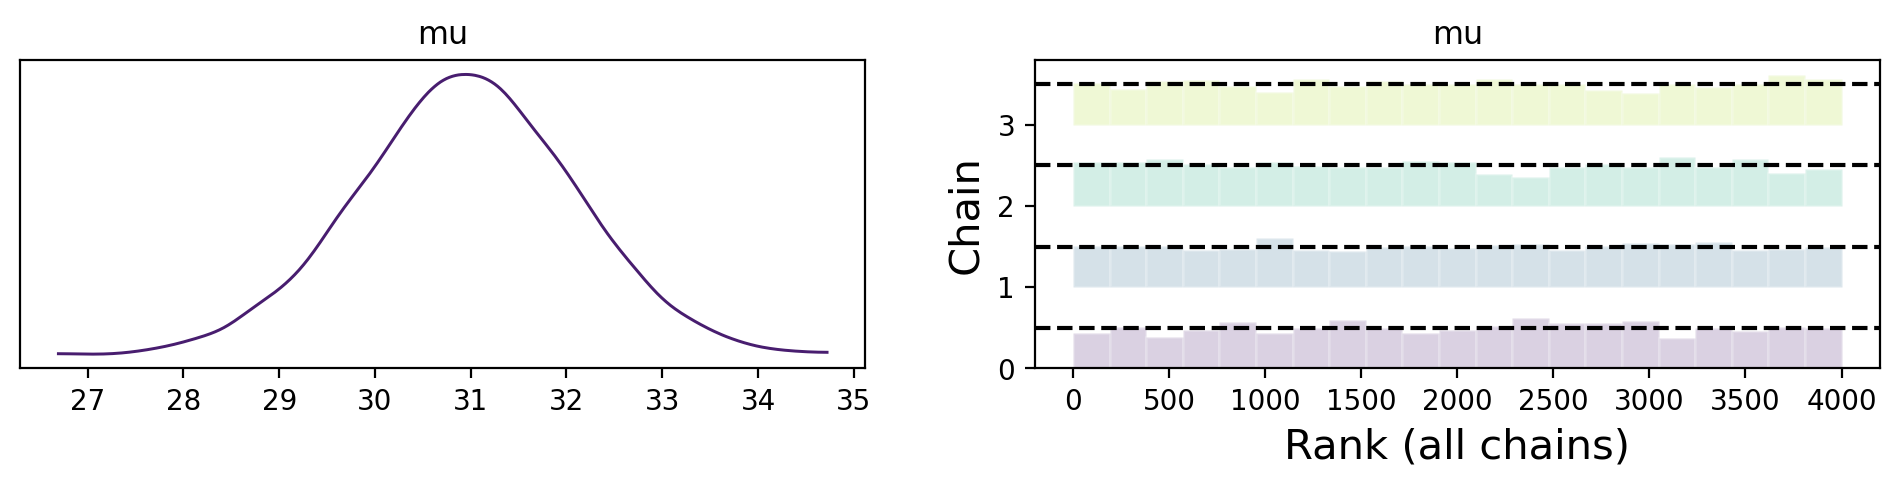

In [18]:
az.plot_trace(idata, combined=True, kind="rank_bars")
plt.show()

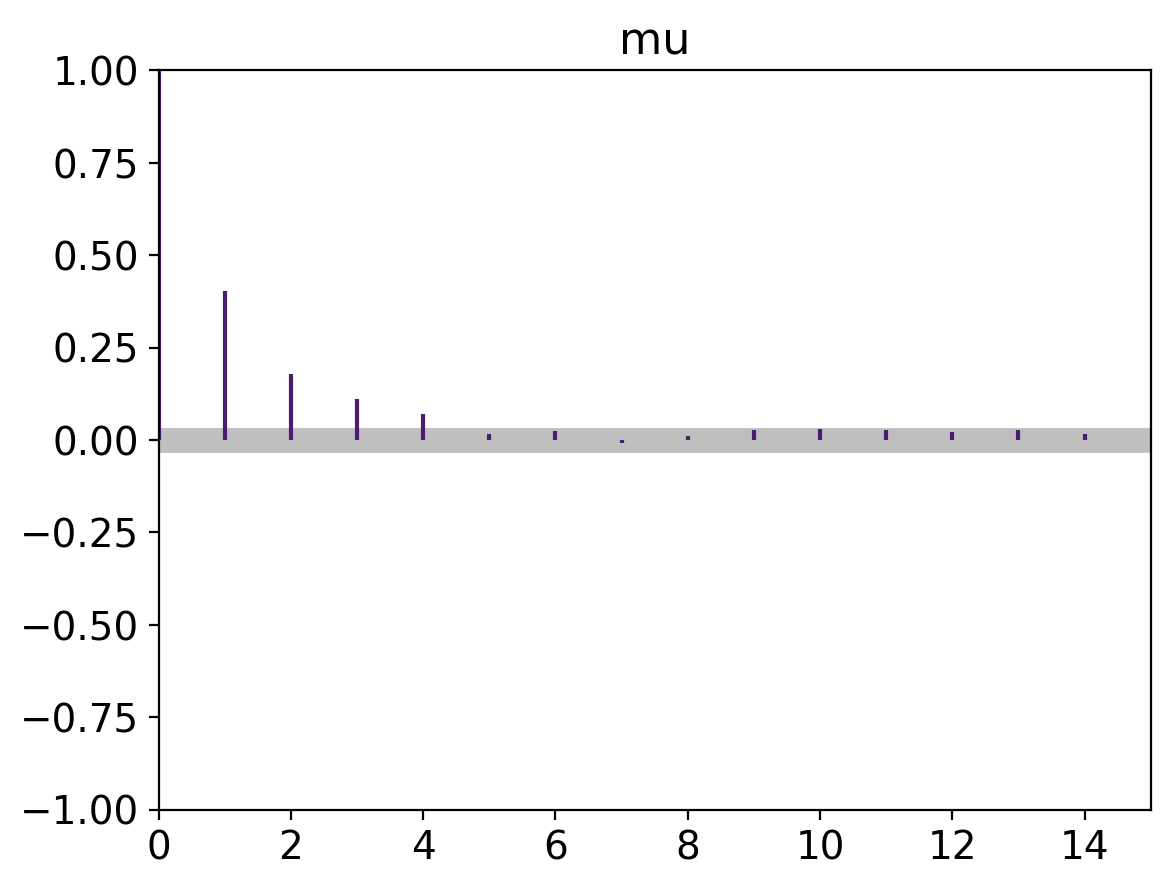

In [19]:
az.plot_autocorr(idata, combined=True, max_lag=15)
plt.show()

In [20]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,30.94,1.14,28.71,33.0,0.03,0.02,1458.66,1653.14,1.0


In [21]:
az.hdi(idata, hdi_prob=0.94)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 28.71 33.0

In [22]:
stats.norm.ppf([0.03, 0.97], loc=30.8836, scale=1.1539)

array([28.71335226, 33.05384774])

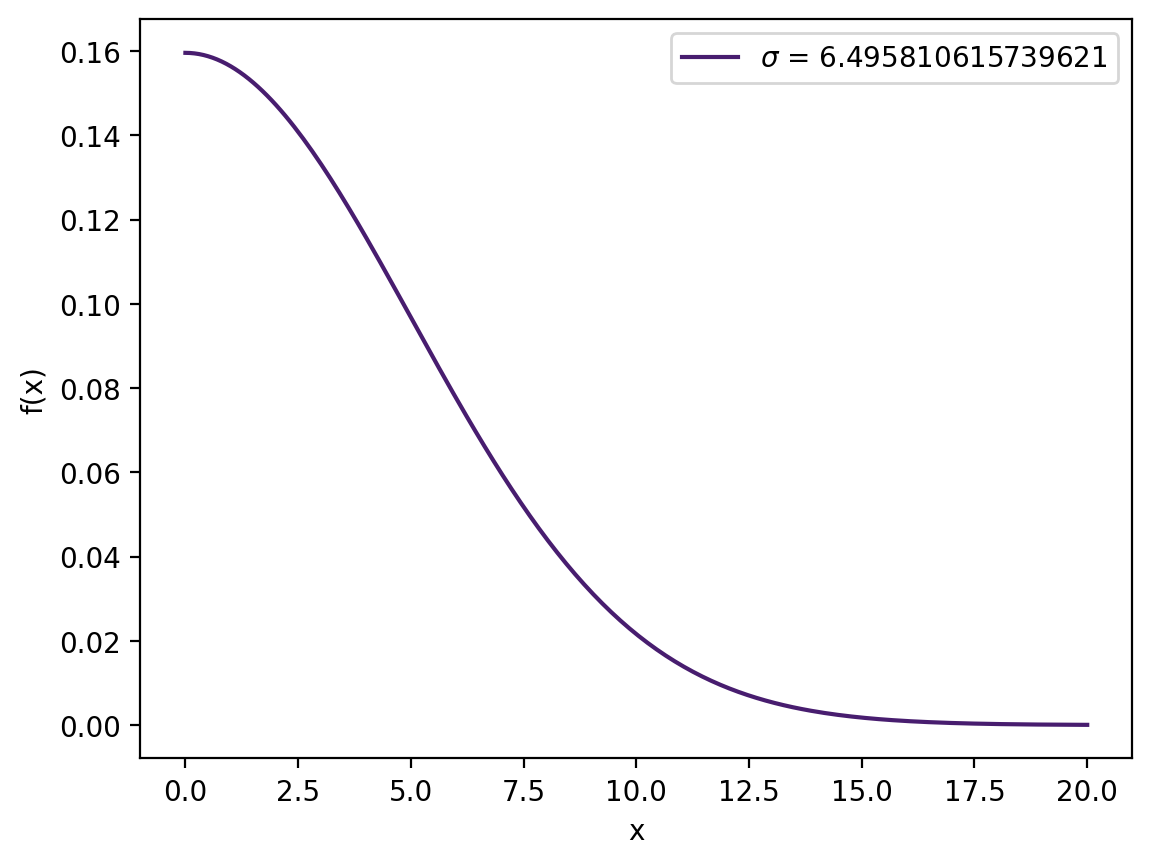

In [23]:
x = np.linspace(0, 20, 200)
pdf = stats.halfnorm.pdf(x, scale=5)
plt.plot(x, pdf, label=r'$\sigma$ = {}'.format(sigma))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend(loc=1)
plt.show()

In [24]:
with pm.Model() as model2:
    data = pm.ConstantData("data", df["y"])
    mu = pm.Normal("mu", mu=30, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=10)
    pm.Normal("y", mu=mu, sigma=sigma, observed=data)

In [25]:
with model2:
    idata2 = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:01.301126
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.331250
Transforming variables...
Transformation time =  0:00:00.014897


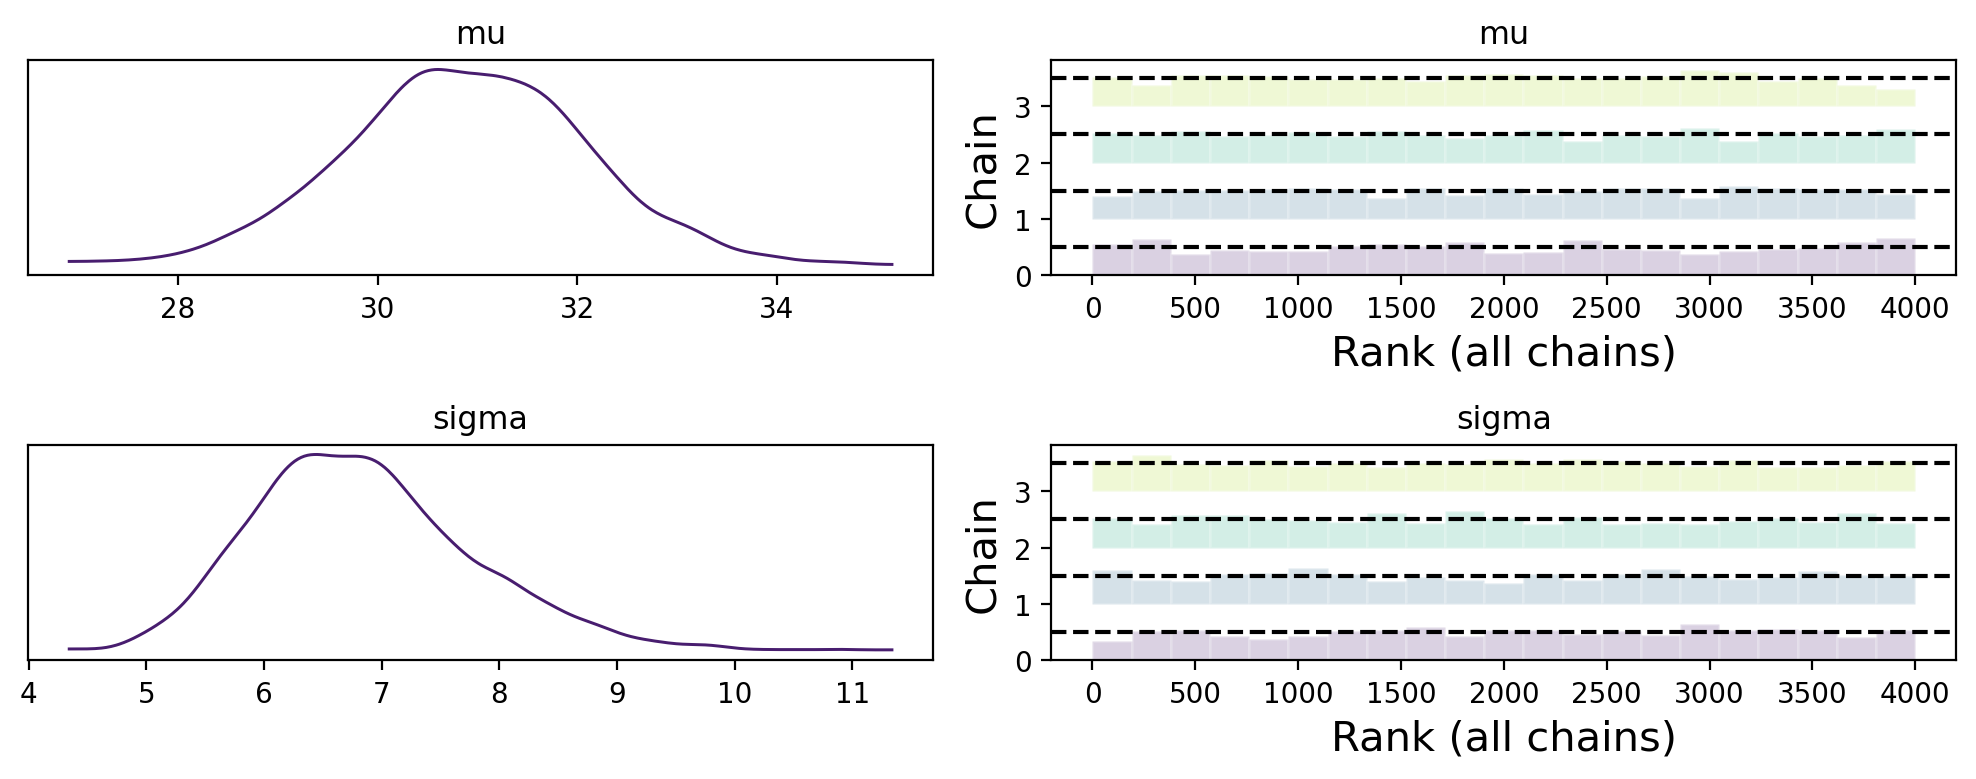

In [26]:
az.plot_trace(idata2, combined=True, kind="rank_bars", figsize=(10, 4))
plt.tight_layout()
plt.show()

In [27]:
az.summary(idata2, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,30.88,1.22,28.51,33.11,0.02,0.02,3033.77,2346.87,1.0
sigma,6.84,0.94,5.16,8.57,0.02,0.01,2665.66,2219.40,1.0


In [28]:
az.hdi(idata2, hdi_prob=0.94)

<xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    mu       (hdi) float64 28.51 33.11
    sigma    (hdi) float64 5.159 8.568

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.12.3

numpy     : 1.25.2
scipy     : 1.10.1
matplotlib: 3.7.2
arviz     : 0.16.0
pandas    : 2.0.3
pymc      : 5.6.1
seaborn   : 0.12.2

Watermark: 2.4.3

